In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Assigning the train and test directory paths
train_dir = '/kaggle/input/historical-structures/HistDataset/Part 1/train'
test_dir = '/kaggle/input/historical-structures/HistDataset/Part 1/test'

In [3]:
# importing the necessary libraries
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow as tf
import numpy as np

# Assigning the variables for a uniform image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_dir = '/kaggle/input/historical-structures/HistDataset/Part 1/train'
test_dir = '/kaggle/input/historical-structures/HistDataset/Part 1/test'

# Splitting the training dataset into training and validation dataset
train_ds = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
# Preparing the test dataset
test_ds = image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    shuffle=False,
    batch_size=1
)
# Retriving the list of class labels
class_names = train_ds.class_names

2025-08-04 07:11:22.310387: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754291482.638469      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754291482.733583      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 10543 files belonging to 11 classes.
Using 8435 files for training.


I0000 00:00:1754291506.383229      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754291506.383947      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 10543 files belonging to 11 classes.
Using 2108 files for validation.
Found 1474 files belonging to 10 classes.


In [4]:
# Use prefetching to load the next batch while the current one is being processed, 
# reducing training latency. AUTOTUNE lets TF pick the optimal buffer size.
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [5]:
# Load ResNet50 (pretrained on ImageNet) without its top classification layer.
# Freeze base model weights to retain learned features.
# Add Global Average Pooling to reduce feature maps, 
# Dropout for regularization, and Dense softmax for 11 output classes.
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

base_model = ResNet50(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(11, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
# Fit the model on train_ds for 5 epochs, 
# using val_ds to monitor validation loss/accuracy after each epoch.
# 'history' stores training metrics for later analysis/plotting.
history = model.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5


I0000 00:00:1754291527.660862      69 service.cc:148] XLA service 0x7895e0003cc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754291527.662484      69 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754291527.662506      69 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754291529.229051      69 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/264 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - accuracy: 0.1719 - loss: 2.6661   

I0000 00:00:1754291534.990423      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


264/264 ━━━━━━━━━━━━━━━━━━━━ 56s 147ms/step - accuracy: 0.7575 - loss: 0.7739 - val_accuracy: 0.9421 - val_loss: 0.1716
Epoch 2/5
264/264 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - accuracy: 0.9446 - loss: 0.1801 - val_accuracy: 0.9511 - val_loss: 0.1440
Epoch 3/5
264/264 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - accuracy: 0.9568 - loss: 0.1395 - val_accuracy: 0.9559 - val_loss: 0.1384
Epoch 4/5
264/264 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - accuracy: 0.9609 - loss: 0.1147 - val_accuracy: 0.9511 - val_loss: 0.1465
Epoch 5/5
264/264 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - accuracy: 0.9682 - loss: 0.0975 - val_accuracy: 0.9526 - val_loss: 0.1464


In [7]:
# Evaluate the trained model on the test set and print the test accuracy as a percentage.
loss, acc = model.evaluate(test_ds)
print(f"Test Accuracy: {acc * 100:.2f}%")

1474/1474 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8301 - loss: 0.9812
Test Accuracy: 69.74%


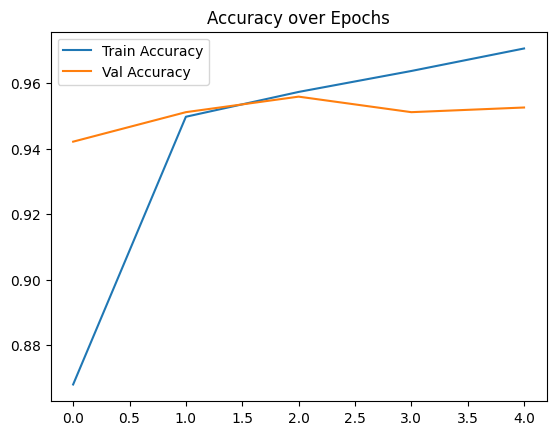

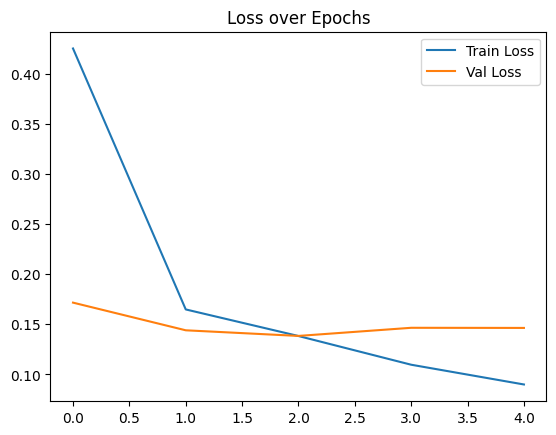

In [8]:
# Plot training & validation accuracy and loss curves to visualize model performance over epochs.
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy over Epochs")
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss over Epochs")
plt.show()

In [9]:
# Iterate over test_ds to collect all labels (y values) into one NumPy array.
# Use Counter to count how many samples belong to each class — useful for checking class imbalance.
import numpy as np
from collections import Counter

labels = np.concatenate([y for x, y in test_ds], axis=0)
print(Counter(labels))

Counter({7: 238, 3: 210, 2: 170, 5: 168, 9: 164, 8: 163, 0: 140, 4: 86, 6: 78, 1: 57})


1474/1474 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step


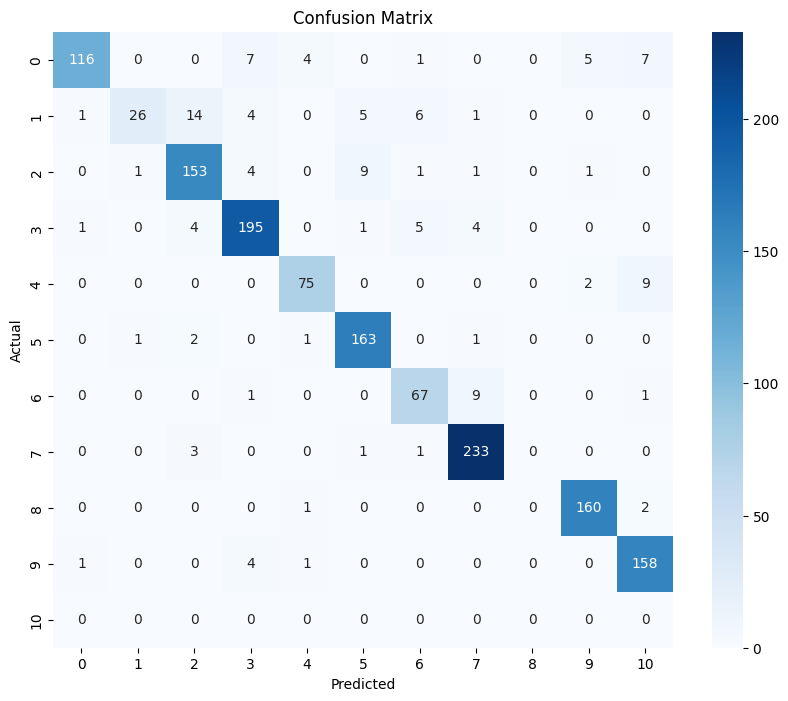

In [10]:
# Generate predictions for the test set, convert them to class indices,
# compute the confusion matrix, and visualize it with a heatmap to assess classification performance.
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Get predictions
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [11]:
# Load EfficientNetB0 pretrained on ImageNet, excluding its top classification layer.
# Freeze its weights to retain learned features.
# Append custom layers: GlobalAveragePooling2D to reduce feature maps,
# Dropout to reduce overfitting, and Dense softmax for 11 output classes.
# Compile the final model with Adam optimizer, sparse categorical crossentropy loss, and accuracy metric.

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

# Load EfficientNetB0 without the top layer
base_model = EfficientNetB0(include_top=False, input_shape=IMG_SIZE + (3,), weights='imagenet')
base_model.trainable = False  # Freeze base

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(11, activation='softmax')(x)  # Adjust number of classes here

# Compile full model
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,063,662 (15.50 MB)

 Trainable params: 14,091 (55.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [12]:
# Train the EfficientNetB0-based model for 10 epochs on the training set,
# validating performance on the validation set after each epoch.
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=10)

Epoch 1/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 59s 125ms/step - accuracy: 0.7426 - loss: 0.9743 - val_accuracy: 0.9417 - val_loss: 0.2176
Epoch 2/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9505 - loss: 0.2011 - val_accuracy: 0.9526 - val_loss: 0.1621
Epoch 3/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9572 - loss: 0.1530 - val_accuracy: 0.9540 - val_loss: 0.1479
Epoch 4/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9666 - loss: 0.1234 - val_accuracy: 0.9564 - val_loss: 0.1305
Epoch 5/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9660 - loss: 0.1126 - val_accuracy: 0.9611 - val_loss: 0.1237
Epoch 6/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9702 - loss: 0.1037 - val_accuracy: 0.9592 - val_loss: 0.1208
Epoch 7/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9722 - loss: 0.0919 - val_accuracy: 0.9620 - val_loss: 0.1180
Epoch 8/10
264/264 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.9722 - loss: 0.0862 -

In [13]:
# Evaluate the trained EfficientNetB0 model on the test dataset
# and print the test accuracy as a percentage.
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

1474/1474 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9192 - loss: 0.5403
Test Accuracy: 74.29%


1474/1474 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step


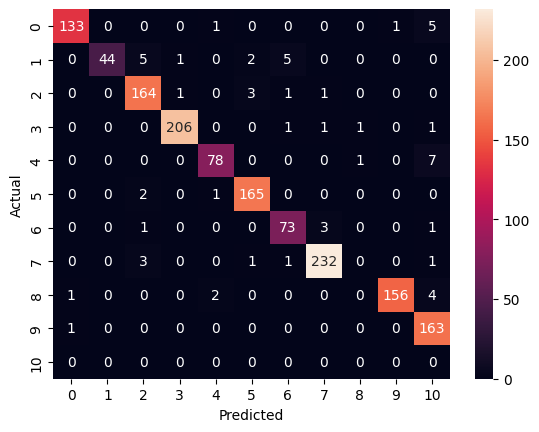

In [14]:
# Predict class probabilities for the test set, convert them to class labels,
# retrieve the true labels, compute the confusion matrix, and visualize it with a heatmap.
y_pred = model.predict(test_ds)
y_pred_labels = np.argmax(y_pred, axis=1)

# Get true labels (if not already)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()